In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from catboost import CatBoostClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import RobustScaler

from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

In [2]:
# train seti : 

train_df = pd.read_excel("train_5.xlsx")

# test seti :

test_features = pd.read_excel("Test_Data.xlsx")
test_target = pd.read_excel("Test_Data_Actual.xlsx")

test_df = pd.concat([test_features, test_target], axis=1)
test_df = test_df.drop(["INDEX","NK_FLAG","ID"], axis=1)
test_df = test_df.rename(columns={'Actual (NK_FLAG)': 'NK_FLAG'})

In [3]:
# preprocessing işleminin fonksiyonelleştirilmiş hali

def preprocessing(df):
    
    # SAYAC_YAPIM_YILI değişkeni için NaN değerlerin median ile doldurulması: 
    df["SAYAC_YAPIM_YILI"] = df["SAYAC_YAPIM_YILI"].fillna(df["SAYAC_YAPIM_YILI"].median())
    
    # SAYAC_MALZEME_ID, SAYAC_OLCUM_TURU ve SAYAC_FAZ_N değişkenlerinde bulunan NaN değerler "MISSING" ile doldurulmuştur:
    df["SAYAC_MALZEME_ID"].fillna("MISSING", inplace=True)
    df["SAYAC_OLCUM_TURU"].fillna("MISSING", inplace=True)
    df["SAYAC_FAZ_N"].fillna("MISSING", inplace=True)
    
    # SAYAC_YAPIM_YILI ve SAYAC_BASLANGIC_TARIHI tarihi kullanılarak "sayac_yas" adlı bir feature oluşturulmuştur: 
    df['year'] = pd.DatetimeIndex(df['SAYAC_BASLANGIC_TARIHI']).year
    df["year"] = df["year"].fillna(df["year"].median())
    df["sayac_yas"] = df['year'] - df["SAYAC_YAPIM_YILI"]

    # TUKETIM ve DEMAND değişkenleri için NaN değerler ilgili satırın ortalamasıyla doldurulmuştur:
    col_base = ("TUKETIM", "DEMAND")
    for col in df.columns:
        if col.startswith(col_base):
            df[col].fillna(df[col].mean(), inplace=True)
            
    # Aylık tüketimler arasındaki oransal fark bulunup "ORAN_X" adlı feature'lar oluşturulmuştur:
    for i in range(1,24):
        df[f"ORAN_{i}"] = (abs(df[f"TUKETIM_M{i+1}"]-df[f"TUKETIM_M{i}"]) / df[f"TUKETIM_M{i}"])*100
        
    df = df.fillna(0)
    df = df.replace([np.inf, -np.inf], 0)
    
    # SAYAC_MALZEME_ID string tipine dönüştürülmüştür : 
    new_cat_cols = ['SAYAC_MALZEME_ID']
    for col in new_cat_cols:
        df[col] = df[col].astype(str)
        
    # İşlem yapılmayacak kolonların veri seti içerisinden çıkartılması:
    df = df.drop(['year', "SAYAC_BASLANGIC_TARIHI", "SAYAC_YAPIM_YILI", "SAYAC_MARKA", "SAYAC_MODEL", 
                  "SAYAC_TAKILMA_TARIHI", "SAYAC_BITIS_TARIHI"], axis = 1)
    return df

In [4]:
# Oluşturulan fonksiyon çağrılarak ayrı ayrı test ve train dataframe'leri için tüm preprocessing işlemlerini gerçekleştirir:

train_df = preprocessing(train_df)
test_df = preprocessing(test_df)

In [5]:
# encode edilecek kolonların seçilmesi

columns_to_encode = []

for col in train_df.columns:
    if train_df[col].dtype == 'object':
        columns_to_encode.append(col)
print(columns_to_encode)

['TESISAT_TIPI', 'SAYAC_MALZEME_ID', 'SAYAC_OLCUM_TURU', 'SAYAC_FAZ_N']


In [6]:
# scale edilecek kolonların seçilmesi

columns_to_scale = ['TUKETIM_M1', 'TUKETIM_M2', 'TUKETIM_M3', 'TUKETIM_M4', 'TUKETIM_M5',
                        'TUKETIM_M6', 'TUKETIM_M7', 'TUKETIM_M8', 'TUKETIM_M9', 'TUKETIM_M10',
                        'TUKETIM_M11', 'TUKETIM_M12', 'TUKETIM_M13', 'TUKETIM_M14',
                        'TUKETIM_M15', 'TUKETIM_M16', 'TUKETIM_M17', 'TUKETIM_M18',
                        'TUKETIM_M19', 'TUKETIM_M20', 'TUKETIM_M21', 'TUKETIM_M22',
                        'TUKETIM_M23', 'TUKETIM_M24', 'DEMAND_M1', 'DEMAND_M2', 'DEMAND_M3',
                        'DEMAND_M4', 'DEMAND_M5', 'DEMAND_M6', 'DEMAND_M7', 'DEMAND_M8',
                        'DEMAND_M9', 'DEMAND_M10', 'DEMAND_M11', 'DEMAND_M12', 'SOB_RISK_SKORU',
                        'SOKAK_RISK_SKORU', "MAHALLE_RISK_SKORU", "sayac_yas", 'ORAN_1',
                    'ORAN_2','ORAN_3','ORAN_4','ORAN_5','ORAN_6','ORAN_7','ORAN_8','ORAN_9',
                    'ORAN_10','ORAN_11','ORAN_12','ORAN_13','ORAN_14','ORAN_15','ORAN_16','ORAN_17',
                    'ORAN_18','ORAN_19','ORAN_20','ORAN_21','ORAN_22','ORAN_23']

In [7]:
# encode ve scale işlemleri: 

rs = RobustScaler()
ohe = OneHotEncoder(handle_unknown='ignore', dtype="int64")

ct = make_column_transformer((ohe, columns_to_encode), remainder="passthrough")
train_df = pd.DataFrame(ct.fit_transform(train_df), columns=ct.get_feature_names())
test_df = pd.DataFrame(ct.transform(test_df),columns=ct.get_feature_names())

train_df[columns_to_scale] = rs.fit_transform(train_df[columns_to_scale])
test_df[columns_to_scale] = rs.fit_transform(test_df[columns_to_scale])

In [8]:
# train_df'in target ve diğer değişkenlerinin ayrılması: 

X = train_df.loc[:, train_df.columns != 'NK_FLAG']
y = train_df["NK_FLAG"]

<AxesSubplot:xlabel='NK_FLAG', ylabel='count'>

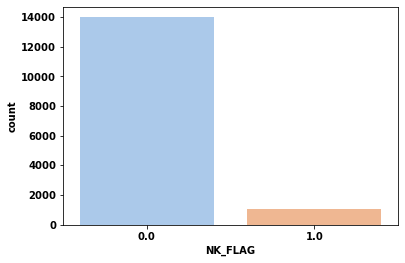

In [9]:
# oversampling öncesi target değişkenin dağılımı

chck = pd.DataFrame()
chck['NK_FLAG'] = y

sns.countplot(chck['NK_FLAG'],palette="pastel")

In [10]:
# train için ayrılan train_df'i kendi içinde train ve test olarak böldükten sonra, oversampling uygulaması: 
# oversampling yapıldı ve 1'ler 0'ların yarısı oranına getirildi

oversample = SMOTE(sampling_strategy=0.5,random_state=9)
X_over, y_over = oversample.fit_resample(X, y)

<AxesSubplot:xlabel='NK_FLAG', ylabel='count'>

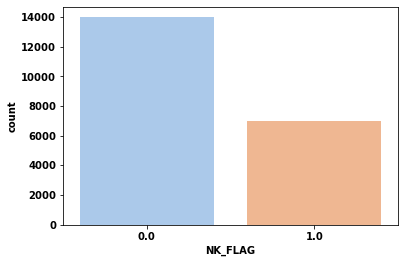

In [11]:
# oversampling sonrası target değişkenin dağılımı

chck2 = pd.DataFrame()
chck2['NK_FLAG'] = y_over

sns.countplot(chck2['NK_FLAG'],palette="pastel")

## Model ve Tahmin
### Train Seti ile Catboost modelinin eğitilmesi ve test verileriyle karşılaştırılması :

In [12]:
# test setinden hedef değişken ile diğer değişkenlerin ayrıştırılması: 

X_test = test_df.loc[:, test_df.columns != 'NK_FLAG']
y_actual = test_df["NK_FLAG"]

In [13]:
from catboost import CatBoostClassifier

## catboost modelinin oluşturulması: 

cbc = CatBoostClassifier(silent=True, random_state=111)

cbc.fit(X_over, y_over)

96.94
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      4687
         1.0       0.83      0.65      0.73       313

    accuracy                           0.97      5000
   macro avg       0.90      0.82      0.85      5000
weighted avg       0.97      0.97      0.97      5000



<AxesSubplot:>

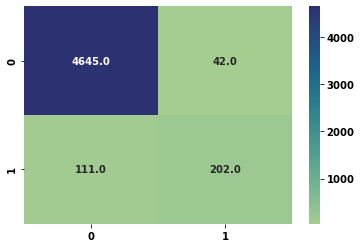

In [14]:
# modelin test seti üzerinde tahminlemesi

preds = cbc.predict(X_test)

score = cbc.score(X_test, y_actual)
print(score*100)
print(classification_report(y_actual, preds))

cm = confusion_matrix(y_actual, preds)
sns.heatmap(cm, annot=True, fmt='.1f', cmap="crest")

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      4687
         1.0       0.72      0.76      0.74       313

    accuracy                           0.97      5000
   macro avg       0.85      0.87      0.86      5000
weighted avg       0.97      0.97      0.97      5000



<AxesSubplot:>

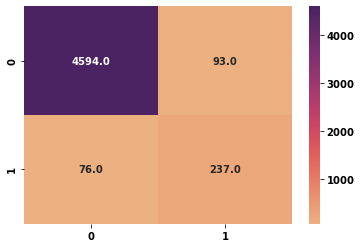

In [15]:
# thresholdun düşürülerek f1 skorunun maksimize edilmiş hali

preds = (cbc.predict_proba(X_test)[:,1] >= 0.29).astype(bool)

print(classification_report(y_actual, preds))
cm = confusion_matrix(y_actual, preds)
sns.heatmap(cm, annot=True, fmt='.1f',cmap="flare")

              precision    recall  f1-score   support

         0.0       0.99      0.94      0.97      4687
         1.0       0.50      0.89      0.64       313

    accuracy                           0.94      5000
   macro avg       0.74      0.92      0.80      5000
weighted avg       0.96      0.94      0.94      5000



<AxesSubplot:>

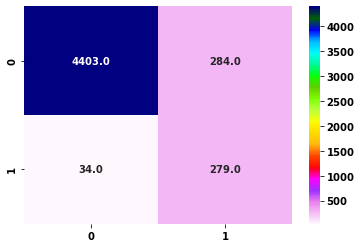

In [16]:
# thresholdun düşürülerek recall skorunun optimize edilmiş hali

preds = (cbc.predict_proba(X_test)[:,1] >= 0.08).astype(bool)

print(classification_report(y_actual, preds))
cm = confusion_matrix(y_actual, preds)
sns.heatmap(cm, annot=True, fmt='.1f',cmap="gist_ncar_r")